<a href="https://colab.research.google.com/github/gitHubAndyLee2020/LLM_Reward_Model_Research/blob/main/Reward_Model_Module_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Prepare Data

In [1]:
from google.colab import files
uploaded = files.upload()

Saving df_train_first1000_ranked.csv to df_train_first1000_ranked.csv


In [2]:
import pandas as pd

# Load the CSV file into a DataFrame
df_train_first1000_ranked = pd.read_csv('df_train_first1000_ranked.csv')
# Replace NaN values with an empty string
df_train_first1000_ranked = df_train_first1000_ranked.fillna('')

In [3]:
df_train_first1000_ranked.head()

,id,system_prompt,question,response,instruct_model_response,openorca_model_response,response_rank,instruct_model_response_rank,openorca_model_response_rank
0,niv.242684,,You will be given a definition of a task first...,"[\n [""AFC Ajax (amateurs)"", ""has ground"", ""Sp...","Sure, I can help you with that task. Can you p...",Here is an example of how the given task shoul...,1,3,2
1,flan.564327,You are an AI assistant. You will be given a t...,Generate an approximately fifteen-word sentenc...,Midsummer House is a moderately priced Chinese...,Midsummer House is a restaurant that serves Ch...,"""Midsummer House is a moderately-priced Chines...",2,3,1
2,flan.1875913,"You are a helpful assistant, who always provid...",What happens next in this paragraph?\n\nShe th...,C. She then dips the needle in ink and using t...,The answer is C. Then dips the needle in ink a...,C. then dips the needle in ink and using the p...,1,3,2
3,t0.408370,You are an AI assistant. You will be given a t...,Please answer the following question: I want t...,"Based on the passage, discuss the primary moti...","Sure, here's a question that could test the ab...","Based on the passage, create a question that a...",1,3,2
4,cot.86217,You are an AI assistant that helps people find...,James runs a TV show and there are 5 main char...,"James pays the minor characters $15,000 each e...","James pays the minor characters $15,000 each e...",James pays the main characters three times mor...,2,3,1


In [4]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 103.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 30.6 MB/s eta 0:00:00


In [5]:
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf

# Load the tokenizer and bert_model
tokenizer = BertTokenizer.from_pretrained("distilbert-base-uncased")
bert_model = TFBertModel.from_pretrained("distilbert-base-uncased")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['distilbert.transformer.layer.1.attention.k_lin.bias', 'distilbert.transformer.layer.5.ffn.lin2.bias', 'distilbert.transformer.layer.2.attention.out_lin.bias', 'distilbert.transformer.layer.0.ffn.lin1.bias', 'distilbert.transformer.layer.0.output_layer_norm.bias', 'distilbert.transformer.layer.5.attention.q_lin.weight', 'distilbert.transformer.layer.5.attention.out_lin.bias', 'distilbert.transformer.layer.5.ffn.lin2.weight', 'distilbert.transformer.layer.1.attention.out_lin.bias', 'distilbert.transformer.layer.5.attention.q_lin.bias', 'distilbert.transformer.layer.2.ffn.lin1.weight', 'distilbert.transformer.layer.3.output_layer_norm.weight', 'distilbert.transformer.layer.4.attention.q_lin.bias', 'distilbert.transformer.layer.0.ffn.lin2.bias', 'vocab_layer_norm.bias', 'distilbert.transformer.layer.2.ffn.lin2.bias', 'vocab_layer_norm.weight', 'distilbert.transformer.layer.3.attention.q_lin.we

In [6]:
import numpy as np

def get_token_counts(df, columns):
    # Tokenize the values in the columns and get the count of tokens for each string
    token_counts = df[columns].applymap(
        lambda x: len(tokenizer.tokenize(str(x)))
    )

    # Convert the DataFrame to a numpy array and then flatten it
    token_counts_array = token_counts.values.flatten()

    return token_counts_array

In [7]:
system_prompt_token_counts = get_token_counts(df_train_first1000_ranked, ['system_prompt'])
question_token_counts = get_token_counts(df_train_first1000_ranked, ['question'])
response_all_token_counts = get_token_counts(df_train_first1000_ranked, ['response', 'instruct_model_response', 'openorca_model_response'])

In [8]:
print("system prompt max length:", system_prompt_token_counts.max())
print("question max length:", question_token_counts.max())
print("response max length:", response_all_token_counts.max())

system prompt max length: 79
question max length: 2224
response max length: 1072


In [9]:
import numpy as np
import matplotlib.pyplot as plt

def graph_distribution(data, bin_size, title):
  bins = np.arange(data.min(), data.max() + bin_size + 1, bin_size)

  # Find the 95% percentile
  percentile_95 = np.percentile(data, 95)

  # Plotting the histogram
  plt.hist(data, bins=bins, edgecolor='black', align='left')
  plt.title(title)
  plt.xlabel('Value Range')
  plt.ylabel('Frequency')
  plt.xticks(bins)
  plt.grid(axis='y')

  # Draw a vertical red line at the 95% percentile
  plt.axvline(percentile_95, color='red', linestyle='dashed', linewidth=1)
  plt.text(percentile_95+1, plt.gca().get_ylim()[1]-5, '95th Percentile', color = 'red')

  # Display the histogram
  plt.show()

  print("95% Percentile at", percentile_95)

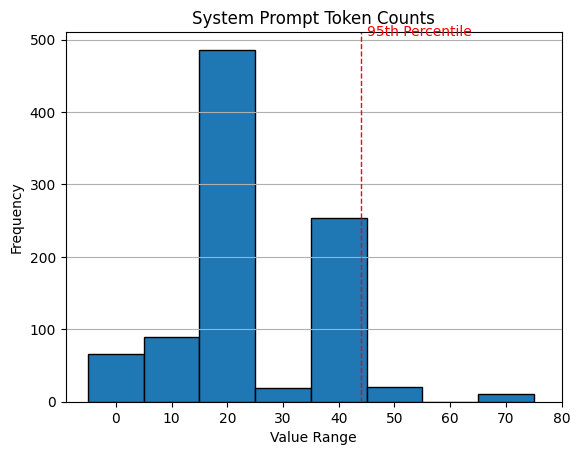

95% Percentile at 44.0


In [10]:
graph_distribution(system_prompt_token_counts, 10, "System Prompt Token Counts")

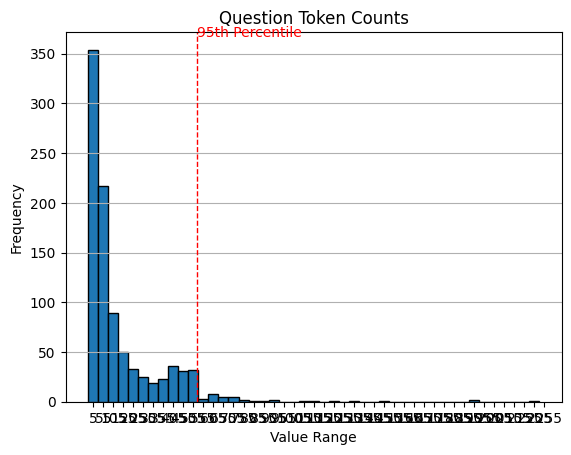

95% Percentile at 521.8499999999999


In [11]:
graph_distribution(question_token_counts, 50, "Question Token Counts")

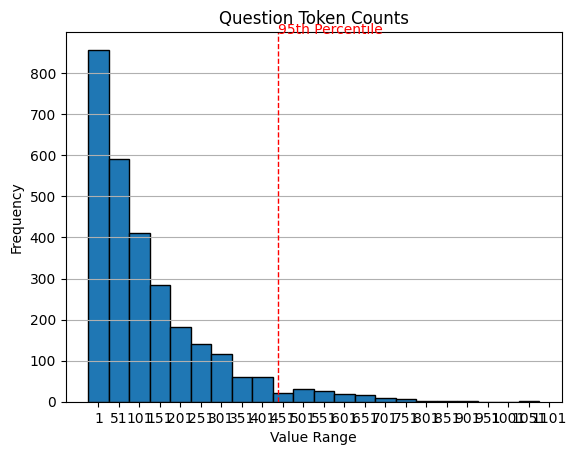

95% Percentile at 438.0


In [12]:
graph_distribution(response_all_token_counts, 50, "Question Token Counts")

In [102]:
def reduce_embeddings(embeddings):
    model = tf.keras.Sequential([
        layers.Conv1D(32, 3, padding='same', activation='relu'),  # Convolve over the sequence length
    ])
    return model(embeddings)

In [103]:
def get_embeddings(sentences, max_length, batch_size=4):
    all_embeddings = []

    for i in range(0, len(sentences), batch_size):
        batch_sentences = sentences[i:i+batch_size]

        # Tokenize the batch of sentences
        tokens = tokenizer(batch_sentences, return_tensors="tf", padding='max_length', truncation=True, max_length=max_length)

        # Get embeddings using the tokens directly
        outputs = bert_model(**tokens)
        embeddings = outputs.last_hidden_state

        # Pad the embeddings tensor to match the max_length
        padding_size = max_length - embeddings.shape[1]
        if padding_size > 0:
            padding = tf.zeros([embeddings.shape[0], padding_size, embeddings.shape[2]])
            embeddings = tf.concat([embeddings, padding], axis=1)

        all_embeddings.append(embeddings)

    # Reducing 768 -> 32 using Conv1D
    pooled_embeddings = reduce_embeddings(tf.concat(all_embeddings, axis=0))
    return pooled_embeddings

In [104]:
MAX_LEN_SYSTEM_PROMPT = int(np.percentile(system_prompt_token_counts, 95))
MAX_LEN_QUESTION = int(np.percentile(question_token_counts, 95))
MAX_LEN_RESPONSE = int(np.percentile(response_all_token_counts, 95))

system_prompt_embeddings = get_embeddings(list(df_train_first1000_ranked['system_prompt']), MAX_LEN_SYSTEM_PROMPT)
question_embeddings = get_embeddings(list(df_train_first1000_ranked['question']), MAX_LEN_QUESTION)
response_embeddings = get_embeddings(list(df_train_first1000_ranked['response']), MAX_LEN_RESPONSE)
instruct_model_response_embeddings = get_embeddings(list(df_train_first1000_ranked['instruct_model_response']), MAX_LEN_RESPONSE)
openorca_model_response_embeddings = get_embeddings(list(df_train_first1000_ranked['openorca_model_response']), MAX_LEN_RESPONSE)

In [105]:
system_prompt_embeddings.shape, question_embeddings.shape, response_embeddings.shape, instruct_model_response_embeddings.shape, openorca_model_response_embeddings.shape

(TensorShape([944, 44, 32]),
 TensorShape([944, 521, 32]),
 TensorShape([944, 438, 32]),
 TensorShape([944, 438, 32]),
 TensorShape([944, 438, 32]))

In [106]:
# Concatenate the embeddings along the sequence length dimension (axis=1)
X = tf.concat([system_prompt_embeddings,
                                     question_embeddings,
                                     response_embeddings,
                                     instruct_model_response_embeddings,
                                     openorca_model_response_embeddings], axis=1).numpy()

In [107]:
import numpy as np

# Create a new column 'tuple_rank' that combines the rankings as a tuple
df_train_first1000_ranked['tuple_rank'] = list(zip(df_train_first1000_ranked['response_rank'],
                                                 df_train_first1000_ranked['instruct_model_response_rank'],
                                                 df_train_first1000_ranked['openorca_model_response_rank']))

# Create a mapping from ranking tuple to one-hot encoded label
rank_map = {
    (1, 2, 3): [1, 0, 0, 0, 0, 0],
    (1, 3, 2): [0, 1, 0, 0, 0, 0],
    (2, 1, 3): [0, 0, 1, 0, 0, 0],
    (2, 3, 1): [0, 0, 0, 1, 0, 0],
    (3, 1, 2): [0, 0, 0, 0, 1, 0],
    (3, 2, 1): [0, 0, 0, 0, 0, 1]
}

# Convert 'tuple_rank' to one-hot encoded labels and assign to y_train
y = np.array(df_train_first1000_ranked['tuple_rank'].map(rank_map).tolist())

In [108]:
from sklearn.model_selection import train_test_split

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print("X_train.shape:", X_train.shape)
print("X_test.shape:", X_test.shape)
print("y_train.shape:", y_train.shape)
print("y_test.shape:", y_test.shape)

X_train.shape: (849, 1879, 32)
X_test.shape: (95, 1879, 32)
y_train.shape: (849, 6)
y_test.shape: (95, 6)


In [109]:
import tensorflow as tf

BATCH_SIZE = 32  # You can change this to any desired batch size

# Convert training data to TensorFlow dataset and batch it
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(X_train))  # shuffle the data
train_dataset = train_dataset.batch(BATCH_SIZE)

# Convert test data to TensorFlow dataset and batch it
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(BATCH_SIZE)

### One-Hot Encoding

- A, B, C -> (1, 2, 3) -> [1, 0, 0, 0, 0, 0]
- A, C, B -> (1, 3, 2) -> [0, 1, 0, 0, 0, 0]
- B, A, C -> (2, 1, 3) -> [0, 0, 1, 0, 0, 0]
- B, C, A -> (2, 3, 1) -> [0, 0, 0, 1, 0, 0]
- C, A, B -> (3, 1, 2) -> [0, 0, 0, 0, 1, 0]
- C, B, A -> (3, 2, 1) -> [0, 0, 0, 0, 0, 1]

### List Reward Model

In [172]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the model
model = tf.keras.Sequential([
    layers.Flatten(input_shape=(X_train.shape[1], X_train.shape[2])),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(6, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_27 (Flatten)        (None, 60128)             0         
                                                                 
 dense_78 (Dense)            (None, 512)               30786048  
                                                                 
 dropout_89 (Dropout)        (None, 512)               0         
                                                                 
 dense_79 (Dense)            (None, 256)               131328    
                                                                 
 dropout_90 (Dropout)        (None, 256)               0         
                                                                 
 dense_80 (Dense)            (None, 6)                 1542      
                                                                 
Total params: 30918918 (117.95 MB)
Trainable params: 

In [167]:
# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2)

Epoch 1/200
22/22 [==============================] - 2s 16ms/step - loss: 8.7001 - accuracy: 0.2725 - val_loss: 1.7798 - val_accuracy: 0.3588
Epoch 2/200
22/22 [==============================] - 0s 7ms/step - loss: 1.8870 - accuracy: 0.3137 - val_loss: 1.7672 - val_accuracy: 0.3529
Epoch 3/200
22/22 [==============================] - 0s 7ms/step - loss: 1.7586 - accuracy: 0.3387 - val_loss: 1.7466 - val_accuracy: 0.3588
Epoch 4/200
22/22 [==============================] - 0s 7ms/step - loss: 1.7423 - accuracy: 0.3049 - val_loss: 1.7308 - val_accuracy: 0.3588
Epoch 5/200
22/22 [==============================] - 0s 7ms/step - loss: 1.7297 - accuracy: 0.3270 - val_loss: 1.7158 - val_accuracy: 0.3588
Epoch 6/200
22/22 [==============================] - 0s 7ms/step - loss: 1.7148 - accuracy: 0.3196 - val_loss: 1.7016 - val_accuracy: 0.3588
Epoch 7/200
22/22 [==============================] - 0s 7ms/step - loss: 1.7005 - accuracy: 0.3535 - val_loss: 1.6886 - val_accuracy: 0.3588
Epoch 8/200


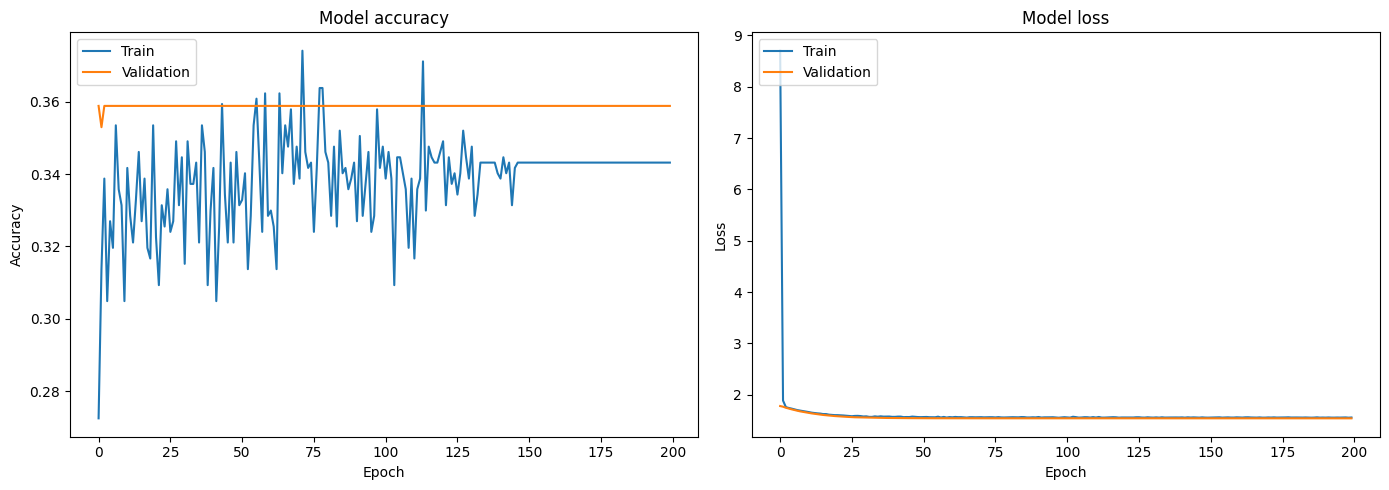

In [168]:
# Plotting training history (optional)
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

In [169]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

3/3 [==============================] - 0s 5ms/step - loss: 1.5711 - accuracy: 0.3684
Test Loss: 1.5711
Test Accuracy: 36.84%


In [171]:
model.save("list_reward_model.h5")

In [173]:
from tensorflow.keras.models import load_model

# Load the model from the .h5 file
loaded_model = load_model("list_reward_model.h5")

# If you want to check the model's architecture after loading
loaded_model.summary()

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_26 (Flatten)        (None, 60128)             0         
                                                                 
 dense_75 (Dense)            (None, 64)                3848256   
                                                                 
 dropout_87 (Dropout)        (None, 64)                0         
                                                                 
 dense_76 (Dense)            (None, 32)                2080      
                                                                 
 dropout_88 (Dropout)        (None, 32)                0         
                                                                 
 dense_77 (Dense)            (None, 6)                 198       
                                                                 
Total params: 3850534 (14.69 MB)
Trainable params: 38

In [174]:
# Evaluate the model on the test data
loss, accuracy = loaded_model.evaluate(X_test, y_test)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

3/3 [==============================] - 0s 6ms/step - loss: 1.5711 - accuracy: 0.3684
Test Loss: 1.5711
Test Accuracy: 36.84%
